# Phase 2 v4 Unified Training Monitor

This notebook monitors the training progress of `scripts/train_phase2_v4_unified.py`.


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Config
log_file = "../logs/training_metrics_v4_unified.csv"
window = 20  # Smoother window for high-res analysis

## 1. Standard Training Loss (Total, CE, KD)

This view shows the overall convergence and the balance between Grammar (CE) and Logic (KD).


Loaded 1095 steps.


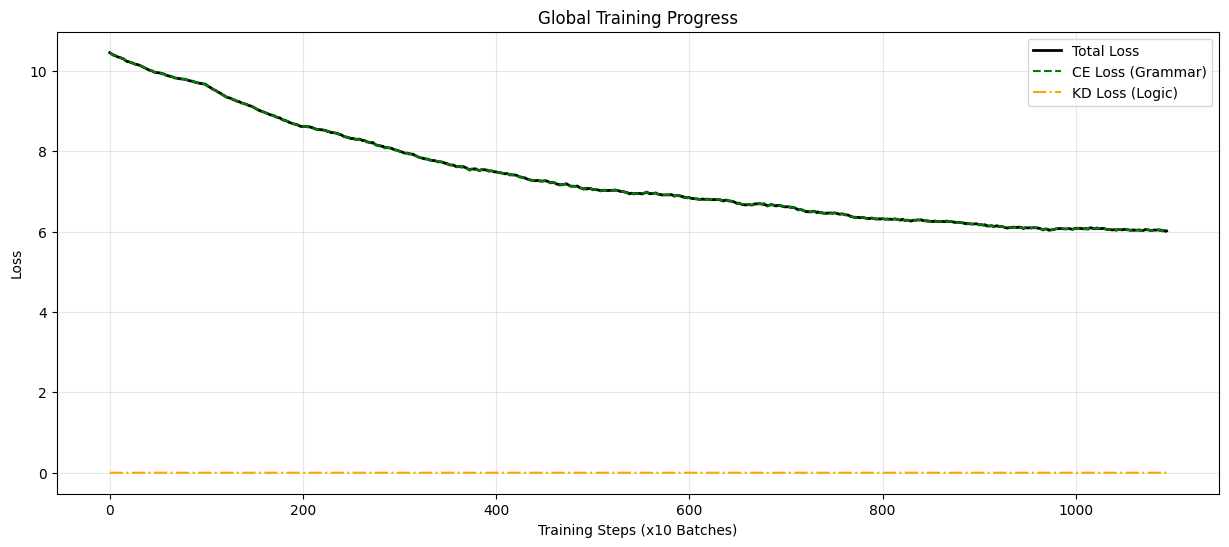

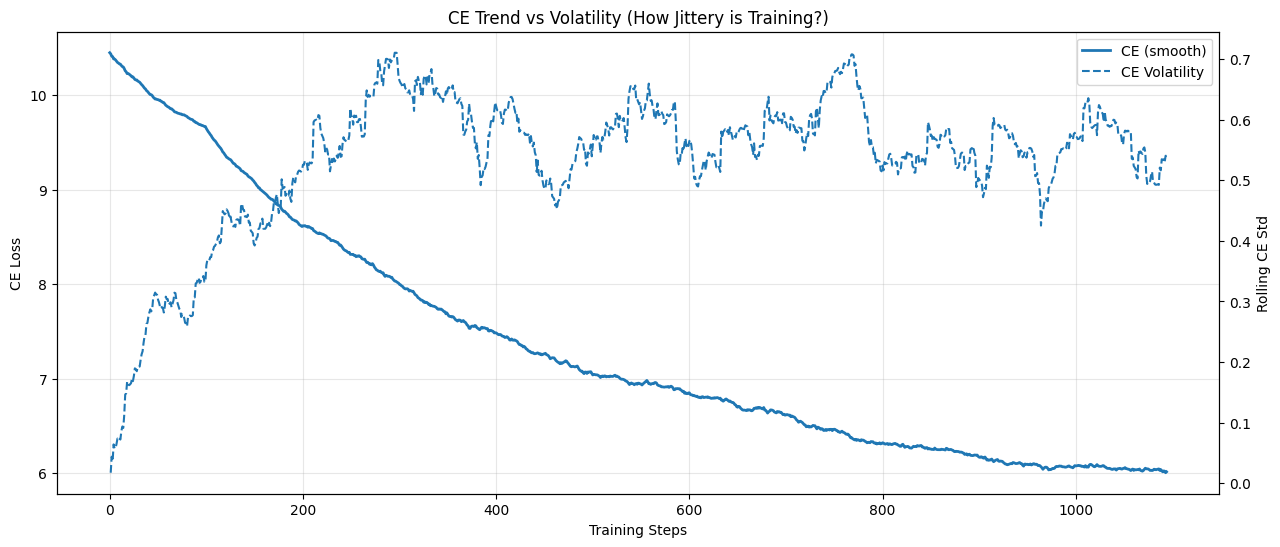

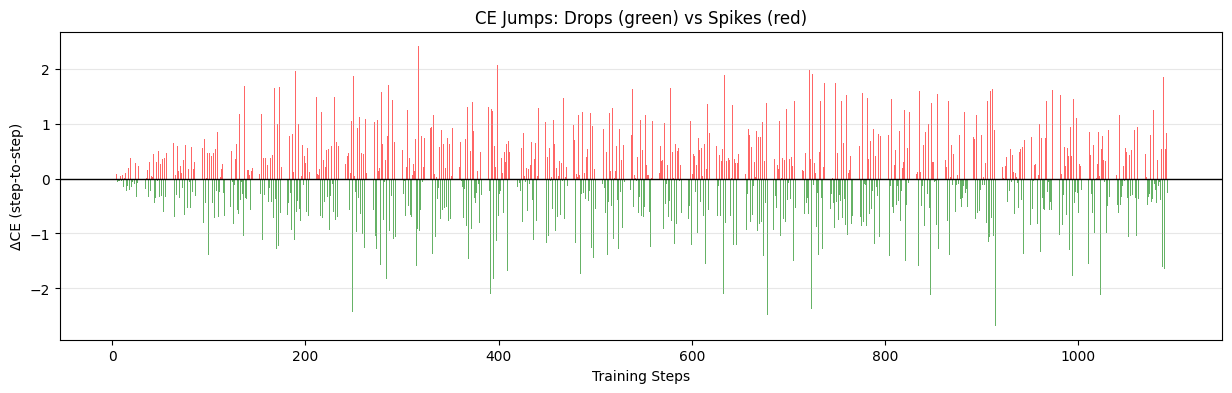

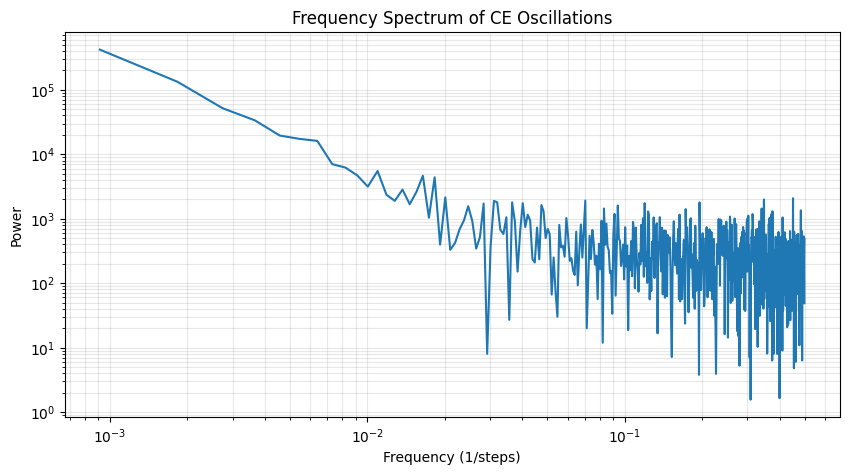

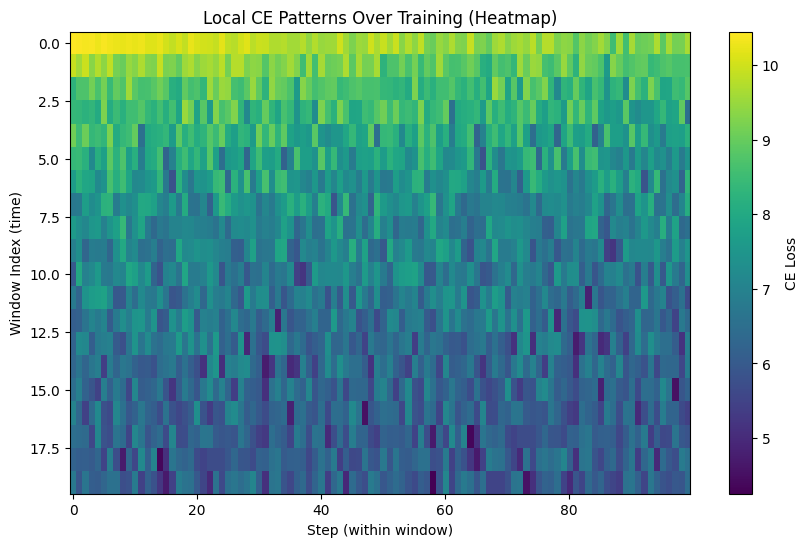

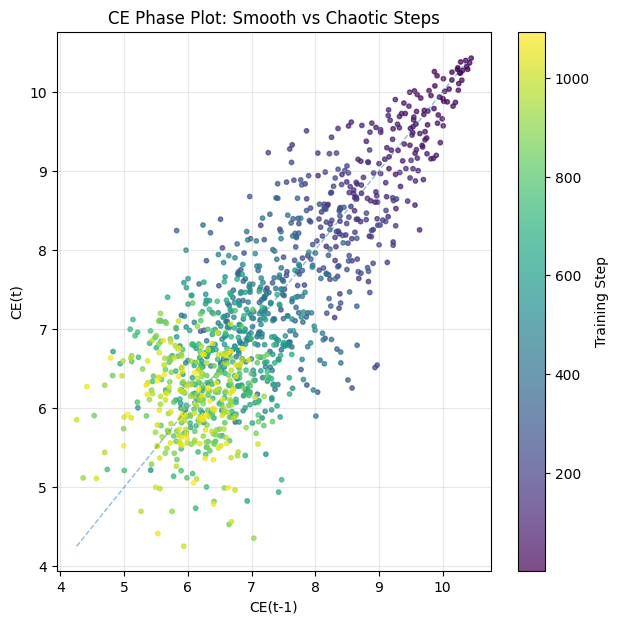

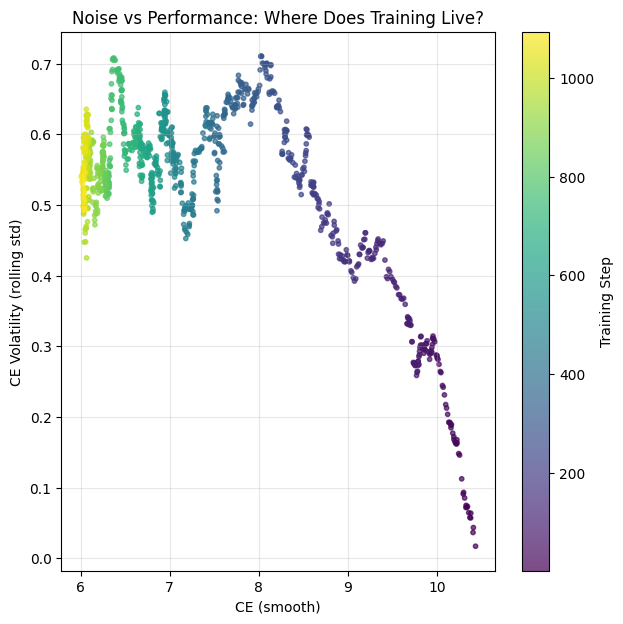

In [51]:
if os.path.exists(log_file):
    try:
        df = pd.read_csv(log_file)
        print(f"Loaded {len(df)} steps.")

        # Smoothing
        df["Total_Smooth"] = df["Total_Loss"].rolling(window, min_periods=1).mean()
        df["CE_Smooth"] = df["CE"].rolling(window, min_periods=1).mean()
        df["KD_Smooth"] = df["KD"].rolling(window, min_periods=1).mean()

        plt.figure(figsize=(15, 6))
        plt.plot(df["Total_Smooth"], label="Total Loss", color="black", linewidth=2)
        plt.plot(
            df["CE_Smooth"], label="CE Loss (Grammar)", color="green", linestyle="--"
        )
        plt.plot(
            df["KD_Smooth"], label="KD Loss (Logic)", color="orange", linestyle="-."
        )
        plt.xlabel("Training Steps (x10 Batches)")
        plt.ylabel("Loss")
        plt.title("Global Training Progress")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    except Exception as e:
        print(f"Error: {e}")
else:
    print("Log file not found.")


vol_window = 50  # or 100, depends on step count

df["CE_Smooth"] = df["CE"].rolling(window, min_periods=1).mean()
df["CE_Vol"] = df["CE"].rolling(vol_window, min_periods=1).std()

fig, ax1 = plt.subplots(figsize=(15, 6))

# CE smooth (main path)
ax1.plot(df.index, df["CE_Smooth"], label="CE (smooth)", linewidth=2)
ax1.set_xlabel("Training Steps")
ax1.set_ylabel("CE Loss")
ax1.grid(True, alpha=0.3)

# Volatility on second axis
ax2 = ax1.twinx()
ax2.plot(df.index, df["CE_Vol"], label="CE Volatility", linestyle="--", linewidth=1.5)
ax2.set_ylabel("Rolling CE Std")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("CE Trend vs Volatility (How Jittery is Training?)")
plt.show()


df["CE_Delta"] = df["CE"].diff()

fig, ax = plt.subplots(figsize=(15, 4))

colors = ["green" if d < 0 else "red" for d in df["CE_Delta"].fillna(0)]
ax.bar(df.index, df["CE_Delta"], color=colors, alpha=0.6)
ax.axhline(0, color="black", linewidth=1)

ax.set_xlabel("Training Steps")
ax.set_ylabel("ΔCE (step-to-step)")
ax.set_title("CE Jumps: Drops (green) vs Spikes (red)")
ax.grid(True, axis="y", alpha=0.3)

plt.show()


ce = df["CE"].values
ce_centered = ce - ce.mean()

freqs = np.fft.rfftfreq(len(ce_centered), d=1.0)  # d=1 step per index
power = np.abs(np.fft.rfft(ce_centered)) ** 2

plt.figure(figsize=(10, 5))
plt.loglog(freqs[1:], power[1:])  # skip 0 freq
plt.xlabel("Frequency (1/steps)")
plt.ylabel("Power")
plt.title("Frequency Spectrum of CE Oscillations")
plt.grid(True, which="both", alpha=0.3)
plt.show()

window = 100
stride = 50

windows = []
for start in range(0, len(df) - window + 1, stride):
    segment = df["CE"].iloc[start : start + window].values
    windows.append(segment)

heat = np.array(windows)

plt.figure(figsize=(10, 6))
plt.imshow(heat, aspect="auto", interpolation="nearest")
plt.colorbar(label="CE Loss")
plt.xlabel("Step (within window)")
plt.ylabel("Window Index (time)")
plt.title("Local CE Patterns Over Training (Heatmap)")
plt.show()


if "Batch_Index" not in df.columns:
    df["Batch_Index"] = np.arange(len(df))

df["CE_prev"] = df["CE"].shift(1)

valid = df.dropna(subset=["CE", "CE_prev"])

plt.figure(figsize=(7, 7))
sc = plt.scatter(
    valid["CE_prev"],
    valid["CE"],
    c=valid["Batch_Index"],
    cmap="viridis",
    s=10,
    alpha=0.7,
)
plt.colorbar(sc, label="Training Step")
plt.plot(
    [valid["CE_prev"].min(), valid["CE_prev"].max()],
    [valid["CE_prev"].min(), valid["CE_prev"].max()],
    linestyle="--",
    linewidth=1,
    alpha=0.5,
)

plt.xlabel("CE(t-1)")
plt.ylabel("CE(t)")
plt.title("CE Phase Plot: Smooth vs Chaotic Steps")
plt.grid(True, alpha=0.3)
plt.show()


# Left side = good loss; right side = bad loss.

# Low y = calm; high y = jittery.

# Ideally points move from (high CE, high vol) → (low CE, low vol).
# If they move to (low CE, high vol) and circle there, you know you’re in the “good but noisy” regime where an LR cooldown or different schedule could buy you stability.

plt.figure(figsize=(7, 7))
sc = plt.scatter(
    df["CE_Smooth"],
    df["CE_Vol"],
    c=df["Batch_Index"],  # or df.index
    cmap="viridis",
    s=10,
    alpha=0.7,
)
plt.colorbar(sc, label="Training Step")

plt.xlabel("CE (smooth)")
plt.ylabel("CE Volatility (rolling std)")
plt.title("Noise vs Performance: Where Does Training Live?")
plt.grid(True, alpha=0.3)
plt.show()

## 2. Quantum Component Analysis (Mag & Phase)

This view analyzes the internal quantum state:

- **Mag Loss (Confidence/Salience):** How confident the model is.
- **Phase Loss (Structure/Uncertainty):** How well it models ambiguity.


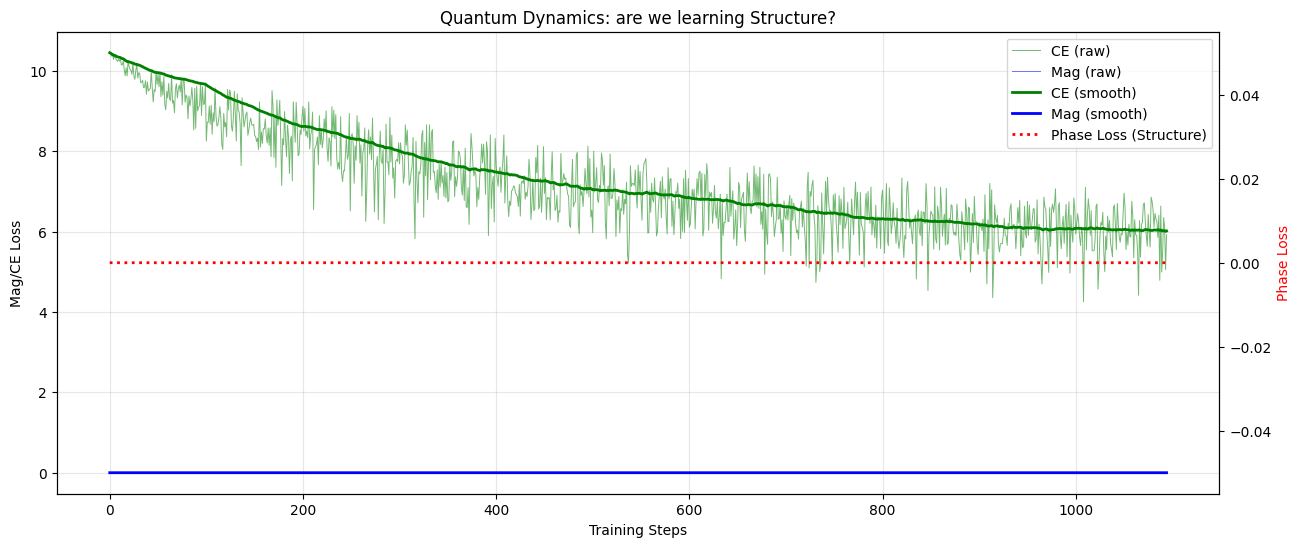

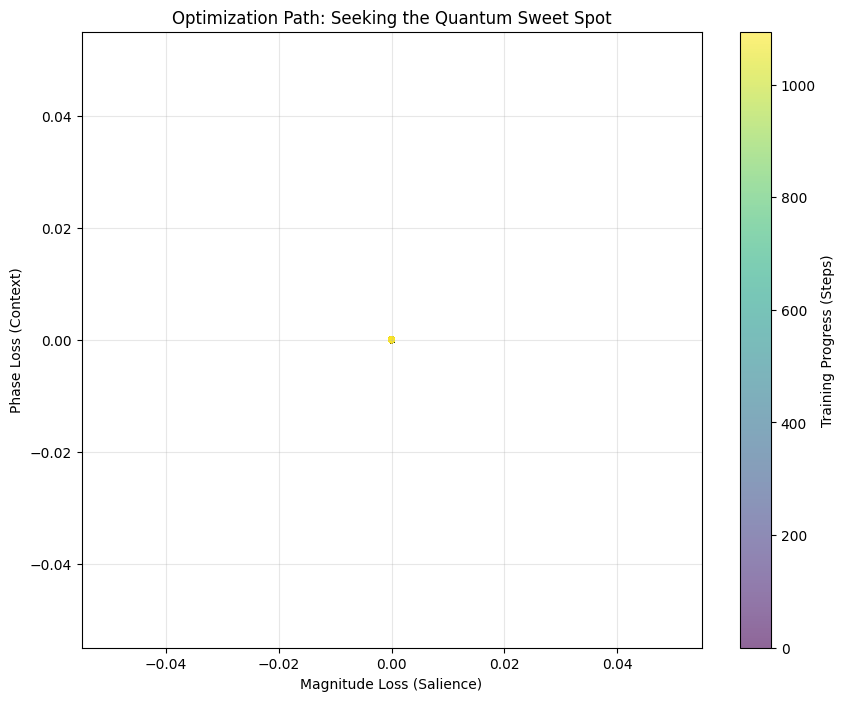

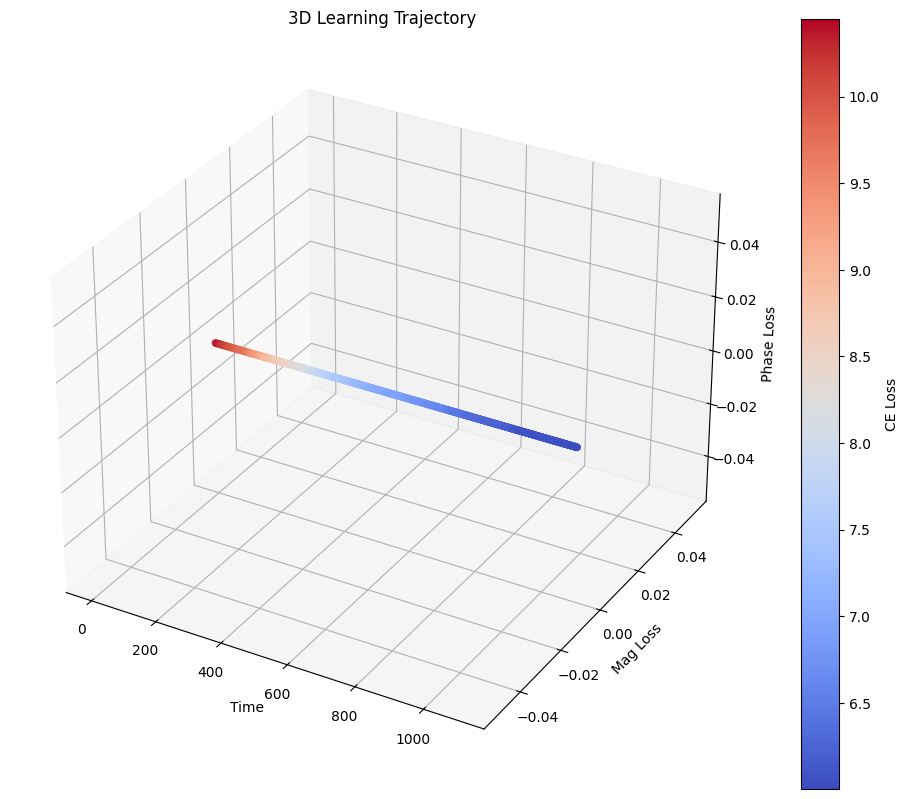

In [53]:
if os.path.exists(log_file):
    try:
        # Keep raw references (for readability)
        ce_raw = df["CE"]
        mag_raw = df["Mag"]
        phase_raw = df["Phase"]

        # Smoothing Quantum Metrics
        df["CE_Smooth"] = ce_raw.rolling(window, min_periods=1).mean()
        df["Mag_Smooth"] = df["Mag"].rolling(window, min_periods=1).mean()
        df["Phase_Smooth"] = df["Phase"].rolling(window, min_periods=1).mean()
        df["Batch_Index"] = df.index

        # --- PLOT 2A: QUANTUM LOSS CURVES ---
        fig, ax1 = plt.subplots(figsize=(15, 6))
        # ax1.plot(df["CE_Smooth"], label="CE Loss", color="green", alpha=0.5)
        # ax1.plot(
        #     df["Mag_Smooth"], label="Mag Loss (Confidence)", color="blue", linewidth=2
        # )
        # ax1.set_xlabel("Training Steps")
        # ax1.set_ylabel("Msg/CE Loss")
        # ax1.grid(True, alpha=0.3)

        # 1) RAW (noisy) curves in lighter color / thinner line
        ax1.plot(ce_raw, label="CE (raw)", color="green", alpha=0.55, linewidth=0.7)
        ax1.plot(mag_raw, label="Mag (raw)", color="blue", alpha=0.55, linewidth=0.7)

        # 2) SMOOTH curves bold on top
        ax1.plot(df["CE_Smooth"], label="CE (smooth)", color="green", linewidth=2)
        ax1.plot(df["Mag_Smooth"], label="Mag (smooth)", color="blue", linewidth=2)

        ax1.set_xlabel("Training Steps")
        ax1.set_ylabel("Mag/CE Loss")
        ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        ax2.plot(
            df["Phase_Smooth"],
            label="Phase Loss (Structure)",
            color="red",
            linestyle=":",
            linewidth=2,
        )
        ax2.set_ylabel("Phase Loss", color="red")

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
        plt.title("Quantum Dynamics: are we learning Structure?")
        plt.show()

        # --- PLOT 2B: PHASE-MAG CORRELATION ---
        plt.figure(figsize=(10, 8))
        sc = plt.scatter(
            df["Mag_Smooth"],
            df["Phase_Smooth"],
            c=df["Batch_Index"],
            cmap="viridis",
            alpha=0.6,
            s=15,
        )
        plt.colorbar(sc, label="Training Progress (Steps)")
        plt.xlabel("Magnitude Loss (Salience)")
        plt.ylabel("Phase Loss (Context)")
        plt.title("Optimization Path: Seeking the Quantum Sweet Spot")
        plt.grid(True, alpha=0.3)
        plt.show()

        # --- PLOT 2C: 3D TRAJECTORY ---
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection="3d")
        p = ax.scatter(
            df["Batch_Index"],
            df["Mag_Smooth"],
            df["Phase_Smooth"],
            c=df["CE_Smooth"],
            cmap="coolwarm",
            s=20,
        )
        ax.set_xlabel("Time")
        ax.set_ylabel("Mag Loss")
        ax.set_zlabel("Phase Loss")
        fig.colorbar(p, label="CE Loss")
        plt.title("3D Learning Trajectory")
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

In [54]:
# TEST CHECKPOINT CELL

import torch
import sys
import os
from transformers import AutoTokenizer

# Add root to path so we can import indra
sys.path.append(os.path.abspath(".."))
from indra.models.quantum_model_v2 import IndraQuantumPhase2

# --- CONFIG ---
checkpoint_path = "../checkpoints/phase2_v4_unified/checkpoint_v4_epoch_1.pt"
prompts = [
    "The future of AI is",
    "Quantum mechanics explains",
    "### Instruction:\nWhat is the capital of France?\n\n### Response:\n",
]
device = "cuda" if torch.cuda.is_available() else "cpu"
# --------------

if os.path.exists(checkpoint_path):
    print(f"Loading {checkpoint_path}...")
    try:
        # Initialize Model (Masking fixed architecture)
        model = IndraQuantumPhase2(32000, 128).to(device)

        # Load with weights_only=False because custom classes might be pickled
        try:
            ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
        except TypeError:
            # Fallback for older torch versions or if param not supported in this context
            ckpt = torch.load(checkpoint_path, map_location=device)

        if "model_state_dict" in ckpt:
            model.load_state_dict(ckpt["model_state_dict"])
        else:
            model.load_state_dict(ckpt)

        model.eval()

        # Check alpha value
        if hasattr(model, "output_layer") and hasattr(model.output_layer, "alpha"):
            alpha_val = (
                torch.nn.functional.softplus(model.output_layer.alpha).item() + 1e-4
            )
            print(f"Current Hybrid Alpha: {alpha_val:.6f}")

        tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

        for p in prompts:
            input_ids = tokenizer.encode(p, return_tensors="pt").to(device)
            print(f"\nPrompt: {p.strip()}")
            print("Output: ", end="")

            # Generate with Sampling
            with torch.no_grad():
                output_ids = input_ids.clone()
                for _ in range(50):
                    # pass Mask=None for inference
                    logits, _, _ = model(output_ids, attention_mask=None)
                    next_token_logits = logits[:, -1, :]

                    # Repetition Penalty
                    repetition_penalty = 1.2
                    for token_id in set(output_ids[0].tolist()):
                        if next_token_logits[0, token_id] < 0:
                            next_token_logits[0, token_id] *= repetition_penalty
                        else:
                            next_token_logits[0, token_id] /= repetition_penalty

                    # Apply Temperature
                    temperature = 0.7
                    probs = torch.nn.functional.softmax(
                        next_token_logits / temperature, dim=-1
                    )

                    # Sample
                    next_token = torch.multinomial(probs, num_samples=1)

                    output_ids = torch.cat([output_ids, next_token], dim=1)
                    token_str = tokenizer.decode(next_token[0])
                    print(token_str, end="", flush=True)
                    if next_token.item() == tokenizer.eos_token_id:
                        break
            print()

    except Exception as e:
        print(f"Error running model: {e}")
else:
    print(f"Checkpoint not found: {checkpoint_path}")

Loading ../checkpoints/phase2_v4_unified/checkpoint_v4_epoch_1.pt...


Current Hybrid Alpha: 0.693747

Prompt: The future of AI is
Output: <unk>morerightresitinensthe</s>

Prompt: Quantum mechanics explains
Output: aone,thearemyinthefocused,and2shaexplorewasizes.new5019-akoftheone6operatingmediacatch@summarytothisdecisiononthe'swithg
TheStartotherset</s>

Prompt: ### Instruction:
What is the capital of France?

### Response:
Output: solutioninalead.</s>
